# Boston house price prediction

刘天润 SC24219058

Import libraries

In [23]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

# Import libraries for building linear regression model
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Import library for preparing data
from sklearn.model_selection import train_test_split

# Import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

## 1. Data analysis

load data

In [24]:
df = pd.read_excel("BostonHousingData.xlsx")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


There are a total of 506 non-null observations in each of the columns. This indicates that there are no missing values in the data.
There are 13 columns in the dataset and every column is of numeric data type.

### 1.1 Exploratory Data Analysis

In [ ]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 1.2 Univariate analysis

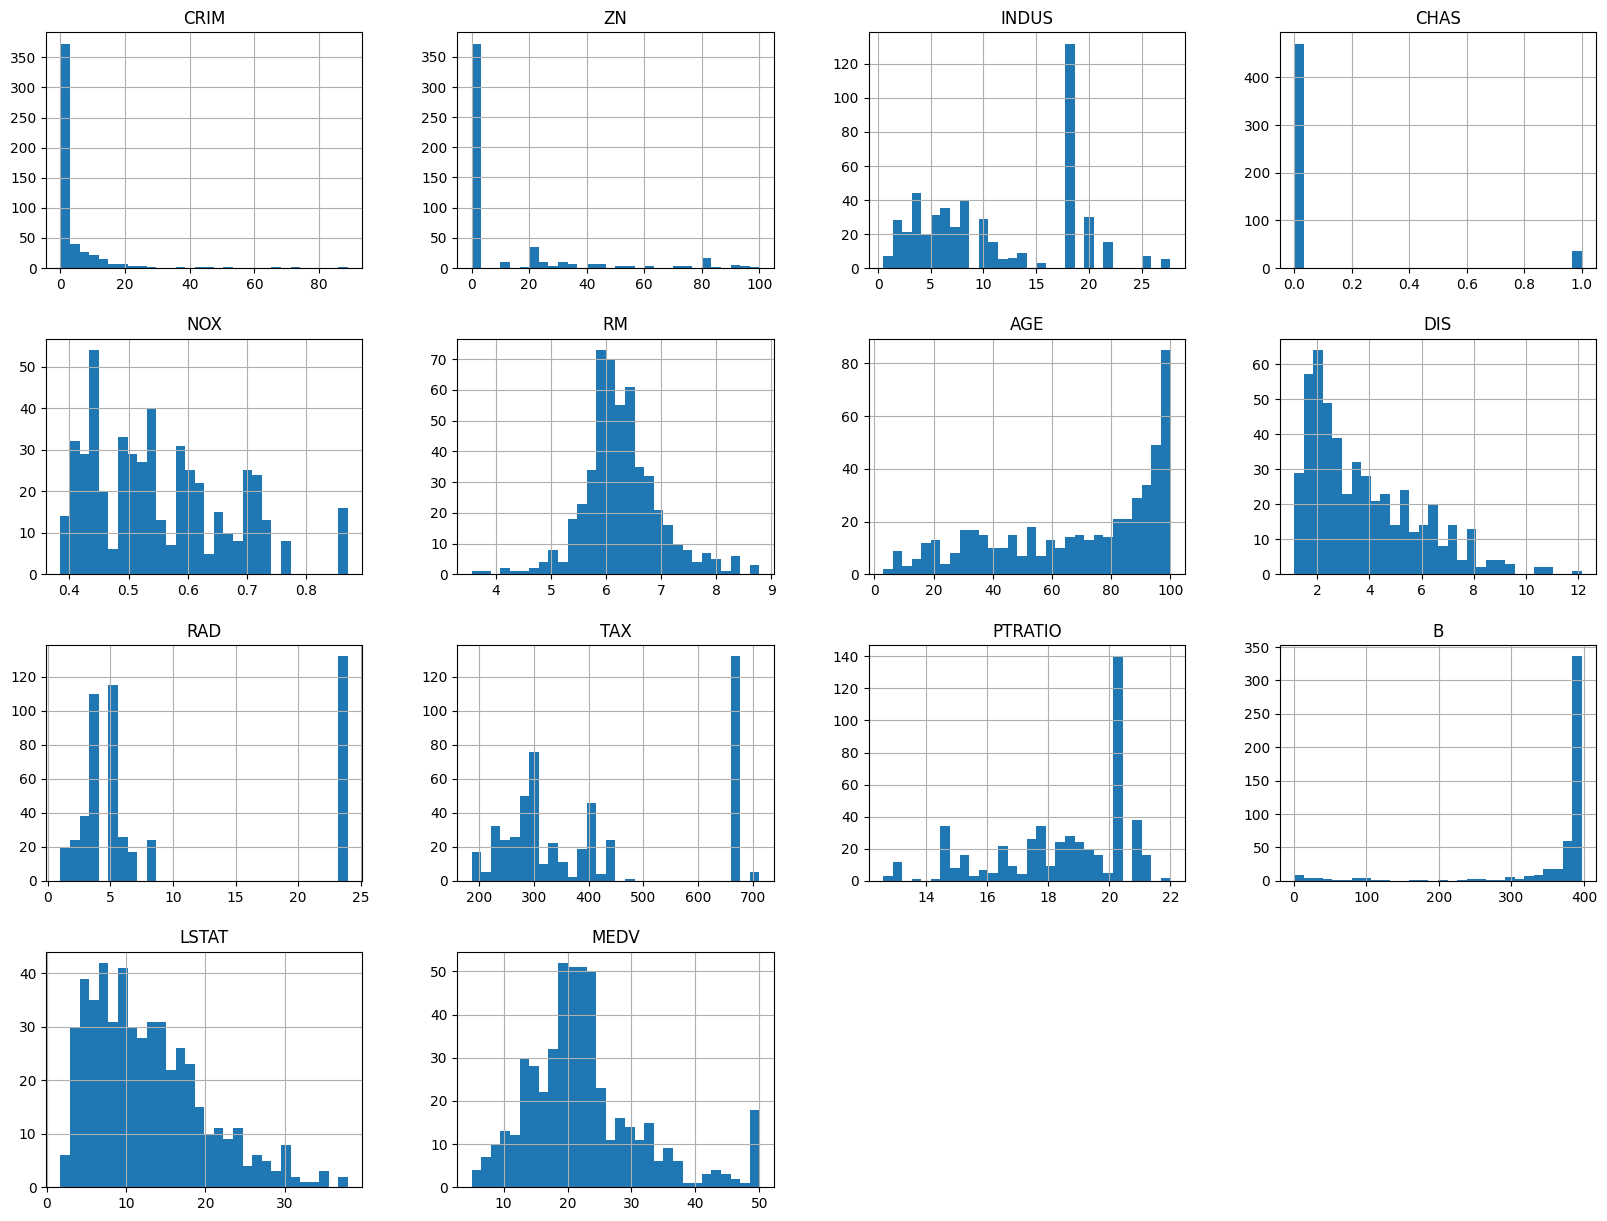

In [26]:
df.hist(bins=30, figsize=(20,15))
plt.show()

MEDV: Median value of owner-occupied homes in 1000 dollars
Slightly skewed. As this is our dependent variable will need to take action to __normalize__ it.

Least squares regression models assume the residuals are normal, and a non-normal dependent variable will produce non-normal residual errors. Therefore, as the dependent variable is sightly skewed, we need to apply a log transformation on the 'MEDV' column and check the distribution of the transformed column.

Note: Using methods like quantile regression and robust regression can use non-normal dependent variables.

<Axes: xlabel='MEDV_log', ylabel='Count'>

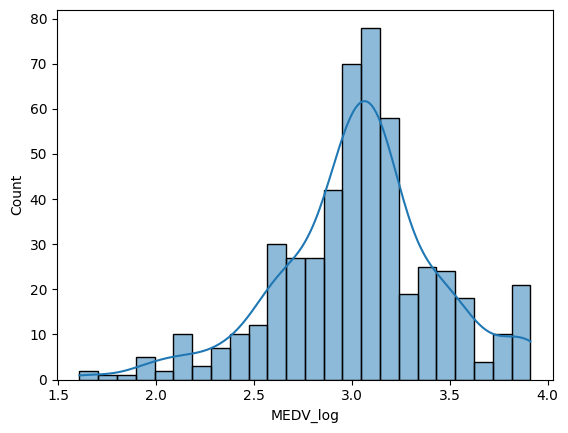

In [27]:
df['MEDV_log'] = np.log(df['MEDV'])
sns.histplot(data = df, x = 'MEDV_log', kde = True)

The log-transformation (MEDV_log) appears to have a nearly normal distribution without skew, therefore we can proceed.

### 1.3 Bivariate Analysis

Check the correlation using heatmap

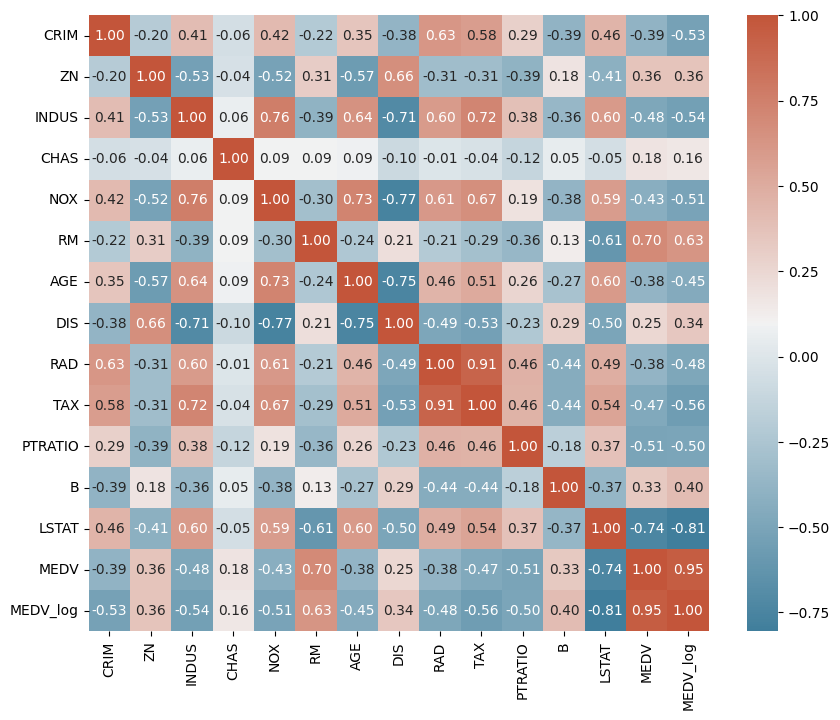

In [28]:
plt.figure(figsize = (10, 8))

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = cmap)

plt.show()

__Strong correlations__ (>= 0.7 or <= -0.7) not involving our dependent variable:

Positive Correlation between NOX and INDUS. Positive Correlation between NOX and AGE. 

Neggative Correlation between DIS and INDUS, DIS and NOX, DIS and AGE. 

Positive Correlation between TAX and INDUS. Very high Positive Correlation between TAX and RAD.

We can reduce the complexity of the model and improve its performance by dropping some highly related features.

### 1.4 Split the dataset

Split the data into the dependent and independent variables and further split it into train and test set in a ratio of 9:1 for train and test sets.

In [29]:
Y = df['MEDV_log']

X = df.drop(columns = {'MEDV', 'MEDV_log'})

# Add the intercept term
X = sm.add_constant(X)

Intercept Term: allows the regression line to be shifted up or down on the y-axis to better fit the data. The value of the intercept term can be interpreted as the expected value of the dependent variable when all independent variables are set to zero.

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

Check for Multicollinearity

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


print(checking_vif(X_train))

    feature         VIF
0     const  576.623113
1      CRIM    1.764090
2        ZN    2.411636
3     INDUS    3.905249
4      CHAS    1.069100
5       NOX    4.383297
6        RM    1.951667
7       AGE    3.106329
8       DIS    4.076094
9       RAD    7.415383
10      TAX    9.040709
11  PTRATIO    1.778923
12        B    1.375459
13    LSTAT    2.949307


There are two variables with a high VIF - RAD and TAX (greater than 5).
Let's remove TAX as it has the highest VIF values and check the multicollinearity again.

In [32]:
# Create the model after dropping TAX
X_train = X_train.drop(columns = 'TAX')

# Check for VIF
print(checking_vif(X_train))

    feature         VIF
0     const  571.121327
1      CRIM    1.763514
2        ZN    2.259899
3     INDUS    3.140632
4      CHAS    1.052977
5       NOX    4.362991
6        RM    1.943733
7       AGE    3.099190
8       DIS    4.075515
9       RAD    2.817402
10  PTRATIO    1.764245
11        B    1.375158
12    LSTAT    2.949012


VIF is less than 5 for all the independent variables, and we can assume that multicollinearity has been removed between the variables.

## 2. Model Building

### 2.1 Linear Regression Model

### 2.1.1 Linear Regression Model1

In [33]:
# Create the model using ordinary least squared
model1 = sm.OLS(y_train,X_train).fit()

# Get the model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MEDV_log   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     130.2
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          1.07e-136
Time:                        14:28:26   Log-Likelihood:                 104.98
No. Observations:                 455   AIC:                            -184.0
Df Residuals:                     442   BIC:                            -130.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0931      0.218     18.743      0.000       3.664       4.522
CRIM          -0.0104      0.001     -7.624      0.000      -0.013      -0.008
ZN             0.0009      0.001      1.442      0.150      -0.000       0.002
INDUS         -0.0027      0.002     -1.152      0.250      -0.007       0.002
CHAS           0.1181      0.036      3.268      0.001       0.047       0.189
NOX           -0.8698      0.165     -5.263      0.000      -1.195      -0.545
RM             0.0894      0.018      4.899      0.000       0.054       0.125
AGE            0.0001      0.001      0.186      0.853      -0.001       0.001
DIS           -0.0521      0.009     -5.940      0.000      -0.069      -0.035
RAD            0.0059      0.002      3.322      0.001       0.002       0.009
PTRATIO       -0.0391      0.006     -6.996      0.000      -0.050      -0.028
B              0.0004      0.000      3.132      0.002       0.000       0.001
LSTAT         -0.0285      0.002    -13.099      0.000      -0.033      -0.024
==============================================================================
Omnibus:                       46.566   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.351
Skew:                           0.351   Prob(JB):                     2.53e-40
Kurtosis:                       6.021   Cond. No.                     1.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared  is at 76.9%, not bad but can be improved.

From the above it may be noted that the regression coefficients corresponding to ZN, AGE, and INDUS are not statistically significant at level α = 0.05. In other words, the regression coefficients corresponding to these three are not significantly different from 0 in the population. 

Hence, I will eliminate the three features and create a new model.

### 2.1.2 Linear Regression Model2

In [34]:
# Create the model after dropping columns 'MEDV', 'MEDV_log', 'TAX', 'ZN', 'AGE', 'INDUS' from df DataFrame
Y = df['MEDV_log']

X = df.drop(['ZN','AGE','INDUS'], axis=1)

X = sm.add_constant(X)

# Splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30 , random_state = 1)

# Create the model
model2 = sm.OLS(y_train,X_train).fit()

# Get the model summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MEDV_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.227e+29
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:28:26   Log-Likelihood:                 11417.
No. Observations:                 354   AIC:                        -2.281e+04
Df Residuals:                     341   BIC:                        -2.276e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.552e-15   5.51e-15     -0.827      0.409   -1.54e-14    6.28e-15
CRIM        1.756e-17   2.53e-17      0.694      0.488   -3.22e-17    6.74e-17
CHAS        8.986e-16   4.85e-16      1.854      0.065   -5.48e-17    1.85e-15
NOX         8.327e-16   2.22e-15      0.376      0.708   -3.53e-15    5.19e-15
RM                  0   2.69e-16          0      1.000   -5.29e-16    5.29e-16
DIS        -2.671e-16   1.02e-16     -2.625      0.009   -4.67e-16    -6.7e-17
RAD        -7.633e-17   4.13e-17     -1.849      0.065   -1.58e-16    4.89e-18
TAX         1.008e-17   2.12e-18      4.755      0.000    5.91e-18    1.43e-17
PTRATIO      1.18e-16    8.3e-17      1.421      0.156   -4.53e-17    2.81e-16
B          -3.195e-18   1.69e-18     -1.893      0.059   -6.51e-18    1.24e-19
LSTAT      -5.204e-17   3.43e-17     -1.515      0.131    -1.2e-16    1.55e-17
MEDV       -1.496e-17   5.93e-17     -0.252      0.801   -1.32e-16    1.02e-16
MEDV_log       1.0000   1.51e-15   6.62e+14      0.000       1.000       1.000
==============================================================================
Omnibus:                       65.598   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.790
Skew:                          -0.415   Prob(JB):                     6.82e-06
Kurtosis:                       2.040   Cond. No.                     2.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-square is great. We still need to check the below linear regression assumptions:

1. Mean of residuals should be 0

2. No Heteroscedasticity
   
3. Linearity of variables

1. Check for mean of residuals

In [35]:
residuals = model2.resid

np.mean(residuals)

1.5568212130619426e-15

The mean of residuals approach 0 hence satisfied the assumption

2. Check for homoscedasticity

In [40]:
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms
name = ["F statistic", "p-value"]

test = sms.het_goldfeldquandt(y_train, X_train)

lzip(name, test)

[('F statistic', 0.0015444518484391964), ('p-value', 0.9999999999999999)]

Since the p-value > 0.95, we accept the Null-Hypothesis hence residuals have homoscedasticity.

3. Linearity of variables
   
Goldfeld-Quandt Test: This test involves dividing the data into two subgroups based on a selected variable and then comparing the variances of the residuals in these subgroups. In Python, you can use het_goldfeldquandt from the statsmodels.stats.diagnostic module. If the variances in the two subgroups are significantly different, it suggests heteroscedasticity.

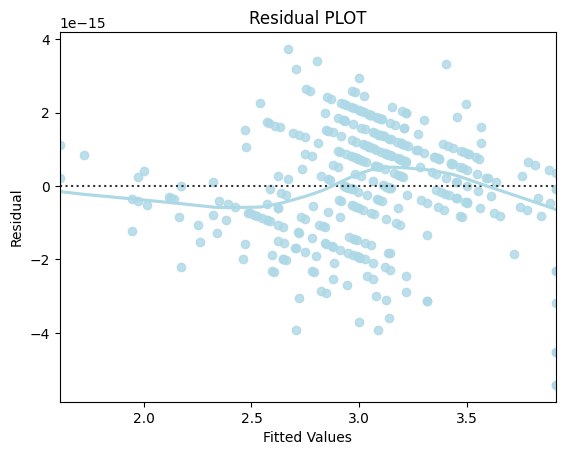

In [41]:
# Predicted values
fitted = model2.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color = "lightblue", lowess = True)

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

There is no pattern in the residual vs fitted values, therefore the assumption is satesfied.


### 2.1.3 Check the performance of the model

In [46]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test):

    # In-sample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
            
            }
        )
    )


# Checking model performance
model_pref(model2, X_train, X_test) 

    Data          RMSE
0  Train  2.381222e-15
1   Test  2.307133e-15


Conclusion:

    The train and test RMSE are very close and approach 0, therefore our model is not overfitted and generalizes well.

### 2.2 Neural Network

